In [1]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import pathlib

# Question 1: git in Practice

My GitHub repository can be found here: https://github.com/SeventhofSages/ASTR8004_HW3

Use command line to create a new git repository and README.md file:

```bash
echo "# ASTR8004_HW3" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin git@github.com:SeventhofSages/ASTR8004_HW3.git
git push -u origin main
```

Create a local branch for ASTRO8004 Homework 3 Question 2:

```bash
git checkout -b Q2

```


# Question 2: Using ADQL to Search for Bright Stars Around the Open Cluster M67


2.1 Download all stars within 1 degree of the center of Messier 67 that are brighter
than G = 14 in Gaia DR3 (the table is called gaiadr.gaia source) and include a
crossmatch these stars with the 2MASS catalog and report your ADQL query text
(use the """query""" notation)

In [2]:
# Define the center of Messier 67
center = SkyCoord(ra=132.825*u.degree,dec=11.8*u.degree, frame='icrs')

# Define the search radius
radius = 1*u.degree

# ADQL Query for all stars within 1 degree of Messier 67 centre 
# Select * selects all columns
# CONTAINS searches for data points inside a geometric shape
# Crossmatch with star IDs in 2MASS catalogue

query = f"""
SELECT g.*, tmass.*  
FROM gaiadr3.gaia_source AS g
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch
ON g.source_id = xmatch.source_id
JOIN gaiadr1.tmass_original_valid AS tmass
ON xmatch.original_ext_source_id = tmass.designation 
WHERE CONTAINS(
    POINT('ICRS', g.ra, g.dec),
    CIRCLE('ICRS', {center.ra.degree}, {center.dec.degree}, {radius.value})
) = 1
AND phot_g_mean_mag < 14
"""

# Launch the query
job = Gaia.launch_job(query)
results = job.get_results()


2.2 Determine how many stars are returned from the initial query.

In [3]:
# Count the number of stars in query results

print(f'Number of stars returned from query: {len(results)}')

Number of stars returned from query: 1018


In [4]:
results

solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,ph_qual,tmass_oid,designation,ra_2,dec_2,err_maj,err_min,err_ang,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,ext_key,j_date
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,,d
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,fl

In [ ]:
# See what columns are in results
results.dtype.names

Struggled to get np.isnan to pick up the 7 "nan" parallax entries. 

Determined the issue is the arrays were masked arrays, and would disregard "nan" entries for any array calculations. 

Have to use "np.array(results['parallax'].mask)" to ensure python would handle as a normal array and not skip over "nan" entries.

In [42]:
# Double check if any NaN in parallax

# np.savetxt('parallax.csv', results['parallax'], delimiter=',')

x = results['parallax'] == "--"

print(np.sum(x))

y = results['parallax'][104]

print(y)

z = np.isnan(results['parallax'])

print(z)

results['parallax'].mask[103:105]

np.sum(results['parallax'].mask)

np.array(results['parallax'].mask)

0
--
[False False False ... False False False]


array([False, False, False, ..., False, False, False])

2.3 Identify any stars with bad 2MASS photometry, where ph qual is not ’AAA’.

Identify any stars with negative (or non-positive) parallaxes in the Gaia data.

In [41]:
# Identify any stars with bas 2MASS photometry, where ph_qual is not 'AAA'

photo_check = results['ph_qual'] != "AAA" 

print(f'There are {np.sum(photo_check)} stars with bad 2MASS photometry: {results[photo_check]["DESIGNATION"]}')

# Identify any stars with negative (or non-positive) parallaxes in the Gaia data

parallax_check = np.array(results['parallax'] < 0) | np.array(results['parallax'].mask)

print(f'There are {np.sum(parallax_check)} stars with negative/NaN parallax: {results[parallax_check]["DESIGNATION"]}')


There are 21 stars with bad 2MASS photometry:         DESIGNATION        
---------------------------
Gaia DR3 598677041873269888
Gaia DR3 598689102141448320
Gaia DR3 598689102142789760
Gaia DR3 598896841119762816
Gaia DR3 598921030375475072
Gaia DR3 598921030375475200
Gaia DR3 598925943818062208
Gaia DR3 598955115237068032
Gaia DR3 608019317296666624
Gaia DR3 608020176290124544
Gaia DR3 604636321880758144
Gaia DR3 604684326730942592
Gaia DR3 604713459494948352
Gaia DR3 604904847532342272
Gaia DR3 604904847532342528
Gaia DR3 604911268507711232
Gaia DR3 604917831219174528
Gaia DR3 604917835513458688
Gaia DR3 604921202767811712
Gaia DR3 604950271106216064
Gaia DR3 605101037342309376
There are 9 stars with negative/NaN parallax:         DESIGNATION        
---------------------------
Gaia DR3 598847569256078464
Gaia DR3 598873953238690816
Gaia DR3 598886739356653696
Gaia DR3 598892580511613312
Gaia DR3 598892580512198144
Gaia DR3 604917663716360576
Gaia DR3 604918282190043648
Gaia DR3 604

2.4 Apply these two quality cuts (removing stars with bad 2MASS photometry and nonpositive
parallaxes). 

After applying the cuts, determine how many stars remain.

In [43]:
# Combine bad photometric and parallax data masks
bad_in = np.bitwise_or(photo_check, parallax_check)

# Generate array of opposite mask 
good_in = np.where(~bad_in)

# Make new clean results table
clean_results = results[good_in]

print(f'Number of stars returned from query: {len(clean_results)}')

Number of stars returned from query: 988


In [44]:
clean_results

solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,ph_qual,tmass_oid,designation,ra_2,dec_2,err_maj,err_min,err_ang,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,ext_key,j_date
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,,d
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,fl

2.5 Using the remaining stars, generate a figure with two panels (1 point per panel):

(a) A color-magnitude diagram (CMD) of Gaia BP-RP vs. absolute G magnitude.

(b) A 2MASS J-Ks vs. apparent K magnitude diagram.

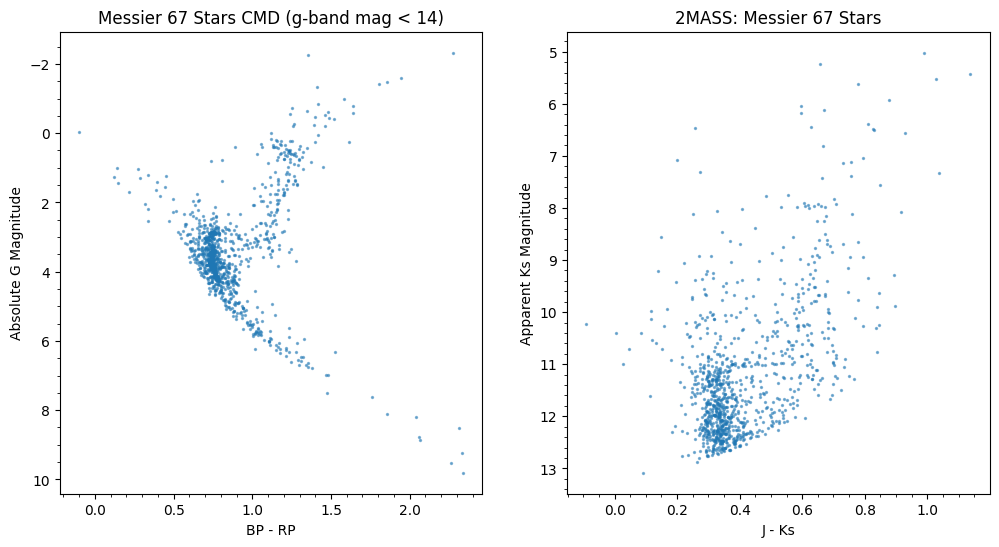

In [45]:
# Calculate absolute G magnitude
abs_g = clean_results['phot_g_mean_mag'] - 5 * np.log10(1000 / clean_results['parallax']) + 5

# Calculate J-Ks 2MASS data
j_ks = clean_results['j_m'] - clean_results['ks_m']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Gaia CMD
ax1.scatter(clean_results['bp_rp'], abs_g, alpha=0.5, s=2)
ax1.set_xlabel('BP - RP')
ax1.set_ylabel('Absolute G Magnitude')
ax1.set_title('Messier 67 Stars CMD (g-band mag < 14)')
ax1.invert_yaxis()
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Plot 2MASS data
ax2.scatter(j_ks, clean_results['ks_m'], alpha=0.5, s=2)
ax2.set_xlabel('J - Ks')
ax2.set_ylabel('Apparent Ks Magnitude')
ax2.set_title('2MASS: Messier 67 Stars')
ax2.invert_yaxis()
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

# Adjust layout and display
# plt.tight_layout()
plt.show()

2.6 Save the figure as figures/cmds M67.png with a resolution of 200 dots per inch.

In [46]:
# Create the 'figures' directory if it doesn't exist
fig_dir = pathlib.Path("figures")
fig_dir.mkdir(exist_ok=True)

# Save the figure
fig.savefig(fig_dir / 'cmds_M67.png', dpi=200, bbox_inches='tight')


2.7 Give your colleague a recommendation for the potential proposal when only judging the fibre usage.